## How to Trade Option Implied Volatility

This notebook will walk through the following key steps in volatility trading.

1.) Understand Volatility

2.) Understand the impact of volatility on an Option's Price

3.) Develop some model that suggests you can profit on a statistical basis 

#### What is Volatility?

Volatility is a fundamental yet enigmatic concept in financial markets - it represents the degree of variation in asset returns over time. Unlike prices which we can directly observe, volatility is a latent (unobservable) quantity that must be estimated from market data.

Mathematically, volatility is often conceptualized as quadratic variation in the return series...
 
 $$\sigma^2 = \frac{1}{T-1}\sum_{t=1}^T (r_t - \bar{r})^2$$
 
 where $r_t$ represents returns at time $t$, $\bar{r}$ is the mean return, and $T$ is the number of observations.

 It's worth noting that this classical definition of volatility as an expectation is somewhat problematic from a theoretical perspective. Unlike sample means which converge nicely due to the Law of Large Numbers (LLN), volatility estimates don't truly converge in the classical sense. This is because financial returns exhibit properties like:

 - Heavy tails that may have infinite variance
 - Strong temporal dependencies
 - Non-stationary behavior

 These characteristics violate the independence and identical distribution assumptions required for traditional LLN convergence. In practice, this means our volatility estimates remain somewhat unstable even with large samples.

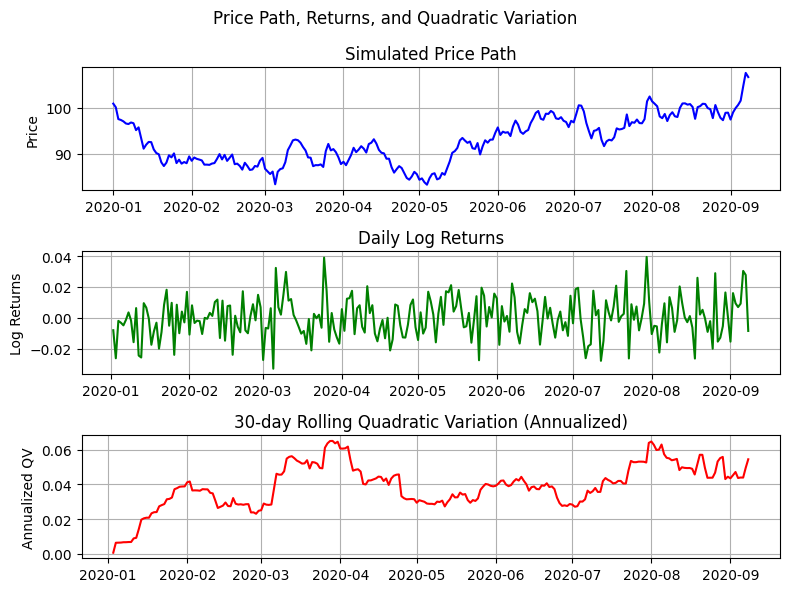

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Generate simulated price path
n_days = 252  # One trading year
dt = 1/252    # Daily time step
mu = 0.05     # Drift (5% annual return)
sigma = 0.2   # Volatility (20% annual)

# Generate random walk
dW = np.random.normal(0, np.sqrt(dt), n_days)
returns = mu*dt + sigma*dW
price_path = 100 * np.exp(np.cumsum(returns))

# Calculate daily returns
daily_returns = np.diff(np.log(price_path))

# Calculate rolling annualized quadratic variation (30-day window)
window = 30
qv = np.array([np.sum(daily_returns[max(0,i-window):i]**2)*252/window 
               for i in range(1, len(daily_returns))])

# Create date range for x-axis
dates = [datetime(2020,1,1) + timedelta(days=x) for x in range(n_days)]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Price Path, Returns, and Quadratic Variation')

# Plot 1: Price path
ax1.plot(dates, price_path, 'b-')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Price Path')
ax1.grid(True)

# Plot 2: Returns
ax2.plot(dates[1:], daily_returns, 'g-')
ax2.set_ylabel('Log Returns')
ax2.set_title('Daily Log Returns')
ax2.grid(True)

# Plot 3: Quadratic Variation
ax3.plot(dates[2:], qv, 'r-')  # Removed *np.sqrt(12) since QV is already annualized with *252
ax3.set_ylabel('Annualized QV')
ax3.set_title(f'{window}-day Rolling Quadratic Variation (Annualized)')
ax3.grid(True)

plt.tight_layout()
plt.show()


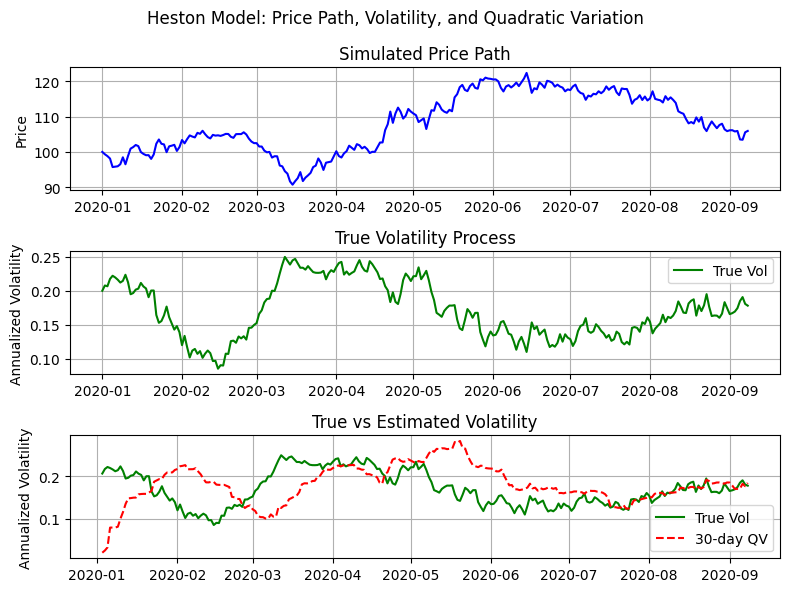


Correlation between 30-day realized QV and true volatility: 0.016


In [2]:
# Heston model parameters
kappa = 2.0    # Mean reversion speed
theta = 0.04   # Long-run variance
xi = 0.3       # Vol of vol
rho = -0.7     # Correlation between price and vol
v0 = 0.04      # Initial variance

# Simulate Heston model
v = np.zeros(n_days)
v[0] = v0
price_path_h = np.zeros(n_days)
price_path_h[0] = 100

# Generate correlated Brownian motions
dW1 = np.random.normal(0, np.sqrt(dt), n_days)
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_days)

# Simulate paths
for t in range(1, n_days):
    v[t] = v[t-1] + kappa*(theta - v[t-1])*dt + xi*np.sqrt(v[t-1])*dW2[t]
    v[t] = max(v[t], 0)  # Ensure variance stays positive
    price_path_h[t] = price_path_h[t-1] * np.exp((mu - 0.5*v[t])*dt + np.sqrt(v[t])*dW1[t])

# Calculate daily returns for Heston
daily_returns_h = np.diff(np.log(price_path_h))

# Calculate rolling QV for Heston
qv_h = np.array([np.sum(daily_returns_h[max(0,i-window):i]**2)*252/window 
                 for i in range(1, len(daily_returns_h))])

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Heston Model: Price Path, Volatility, and Quadratic Variation')

# Plot 1: Price path
ax1.plot(dates, price_path_h, 'b-')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Price Path')
ax1.grid(True)

# Plot 2: True volatility process
ax2.plot(dates, np.sqrt(v), 'g-', label='True Vol')
ax2.set_ylabel('Annualized Volatility')
ax2.set_title('True Volatility Process')
ax2.grid(True)
ax2.legend()

# Plot 3: Quadratic Variation vs True Volatility
ax3.plot(dates[2:], np.sqrt(v[2:]), 'g-', label='True Vol')
ax3.plot(dates[2:], np.sqrt(qv_h), 'r--', label='30-day QV')
ax3.set_ylabel('Annualized Volatility')
ax3.set_title('True vs Estimated Volatility')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Calculate correlation between QV and true volatility
qv_vol_corr = np.corrcoef(np.sqrt(qv_h), np.sqrt(v[2:]))[0,1]
print(f"\nCorrelation between 30-day realized QV and true volatility: {qv_vol_corr:.3f}")


Clearly, this seemingly straightforward statistical measure faces several challenges:

1. **Non-stationarity**: Financial volatility exhibits significant time-variation and clustering, meaning the second moment itself is not stable over time
2. **Regime Changes**: Markets switch between periods of high and low volatility, making consistent estimation difficult
3. **Memory Effects**: Volatility shows persistent patterns and long-range dependencies that simple i.i.d. assumptions fail to capture
4. **Scale Dependence**: The measured volatility can vary significantly based on the sampling frequency and time horizon chosen

These complexities have led to numerous approaches for estimating and forecasting volatility, from simple historical measures to sophisticated stochastic volatility models. Understanding these nuances is crucial for risk management and derivatives pricing.

#### Time Series Analysis Tasks

When working with time series data like volatility measures, there are several key analytical tasks:

### 1. Filtering (Where the heck is vol at NOW?)
Filtering focuses on estimating the current state of a system based on past and present observations. It helps remove noise and extract meaningful signals from raw data. Common filtering techniques include:
- Moving averages
- Kalman filters 
- Exponential smoothing

### 2. Smoothing (Where the heck WAS vol at?)
Smoothing estimates past states using all available data (both past and future observations). This provides a clearer view of underlying trends by reducing noise. Key smoothing approaches include:
- Double exponential smoothing
- Triple exponential smoothing (Holt-Winters)
- LOESS/LOWESS smoothing

### 3. Forecasting (Where the heck WILL vol be at?)
Forecasting predicts future values based on historical patterns. Common forecasting methods include:
- ARIMA/SARIMA models
- Prophet
- Neural networks (LSTM, etc.)
- Exponential smoothing methods

Each of these tasks serves different purposes in time series analysis and can be combined to gain deeper insights into the data.


#### Popular Volatility Models

 * ARCH (Autoregressive Conditional Heteroskedasticity):
   * $\sigma_t^2 = \alpha_0 + \alpha_1\epsilon_{t-1}^2$
   * Where $\epsilon_t$ is the return at time t

 * GARCH (Generalized Autoregressive Conditional Heteroskedasticity):
   * $\sigma_t^2 = \omega + \alpha\epsilon_{t-1}^2 + \beta\sigma_{t-1}^2$
   * Most commonly used GARCH(1,1) model

 * Ornstein-Uhlenbeck Process:
   * $d\sigma_t = \theta(\mu - \sigma_t)dt + \xi dW_t$
   * Where $\theta$ is mean reversion speed, $\mu$ is long-term mean, $\xi$ is volatility of volatility

 * EWMA (Exponentially Weighted Moving Average):
   * $\sigma_t^2 = \lambda\sigma_{t-1}^2 + (1-\lambda)\epsilon_{t-1}^2$
   * Where $\lambda$ is decay factor (typically 0.94 for daily data)

#### Different Realized Volatility Measures

There is no one measure of realized volatility, there are "proprietary" models, calculations, etc. all of which are *probably* proxied via some sort of quadratic variance or standard deviation / variance...

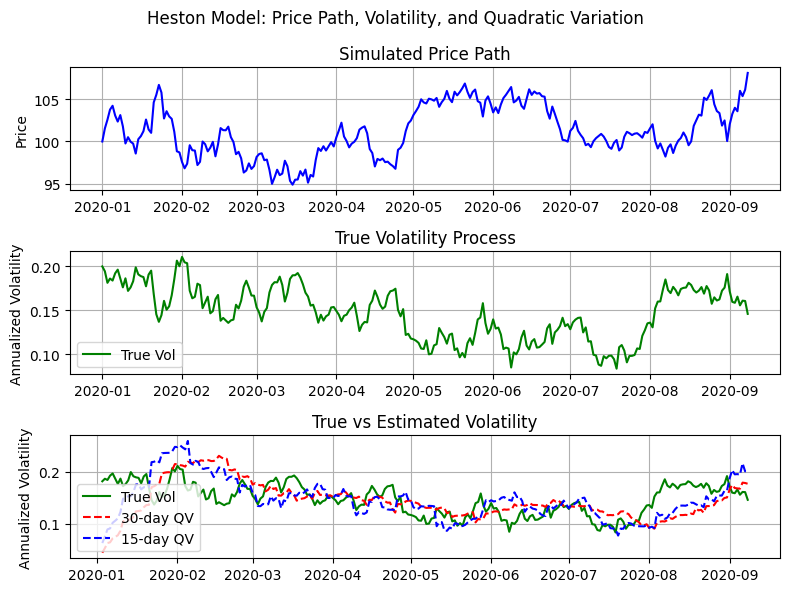


Correlation between 30-day realized QV and true volatility: 0.227
Correlation between 15-day realized QV and true volatility: 0.442


In [3]:
# Heston model parameters
kappa = 2.0    # Mean reversion speed
theta = 0.04   # Long-run variance
xi = 0.3       # Vol of vol
rho = -0.7     # Correlation between price and vol
v0 = 0.04      # Initial variance

# Simulate Heston model
v = np.zeros(n_days)
v[0] = v0
price_path_h = np.zeros(n_days)
price_path_h[0] = 100

# Generate correlated Brownian motions
dW1 = np.random.normal(0, np.sqrt(dt), n_days)
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_days)

# Simulate paths
for t in range(1, n_days):
    v[t] = v[t-1] + kappa*(theta - v[t-1])*dt + xi*np.sqrt(v[t-1])*dW2[t]
    v[t] = max(v[t], 0)  # Ensure variance stays positive
    price_path_h[t] = price_path_h[t-1] * np.exp((mu - 0.5*v[t])*dt + np.sqrt(v[t])*dW1[t])

# Calculate daily returns for Heston
daily_returns_h = np.diff(np.log(price_path_h))

# Calculate rolling QV for different windows
window_30 = 30
window_15 = 15

qv_h_30 = np.array([np.sum(daily_returns_h[max(0,i-window_30):i]**2)*252/window_30 
                    for i in range(1, len(daily_returns_h))])
qv_h_15 = np.array([np.sum(daily_returns_h[max(0,i-window_15):i]**2)*252/window_15 
                    for i in range(1, len(daily_returns_h))])

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Heston Model: Price Path, Volatility, and Quadratic Variation')

# Plot 1: Price path
ax1.plot(dates, price_path_h, 'b-')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Price Path')
ax1.grid(True)

# Plot 2: True volatility process
ax2.plot(dates, np.sqrt(v), 'g-', label='True Vol')
ax2.set_ylabel('Annualized Volatility')
ax2.set_title('True Volatility Process')
ax2.grid(True)
ax2.legend()

# Plot 3: Quadratic Variation vs True Volatility
ax3.plot(dates[2:], np.sqrt(v[2:]), 'g-', label='True Vol')
ax3.plot(dates[2:], np.sqrt(qv_h_30), 'r--', label='30-day QV')
ax3.plot(dates[2:], np.sqrt(qv_h_15), 'b--', label='15-day QV')
ax3.set_ylabel('Annualized Volatility')
ax3.set_title('True vs Estimated Volatility')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Calculate correlations between QV and true volatility
qv_vol_corr_30 = np.corrcoef(np.sqrt(qv_h_30), np.sqrt(v[2:]))[0,1]
qv_vol_corr_15 = np.corrcoef(np.sqrt(qv_h_15), np.sqrt(v[2:]))[0,1]
print(f"\nCorrelation between 30-day realized QV and true volatility: {qv_vol_corr_30:.3f}")
print(f"Correlation between 15-day realized QV and true volatility: {qv_vol_corr_15:.3f}")


#### Implied Volatility v.s Realized Volatility

 Let $F: \Theta \subset \mathbb{R}^d \rightarrow \mathbb{R}$ be an option pricing functional that maps parameter sets to prices, where $\Theta$ includes volatility $\sigma$ along with other parameters like spot price, strike, maturity, etc.

 While $\sigma$ is typically assumed to be a known input to $F$, it is actually unobservable in practice. However, since market supply and demand determine actual option prices $P_{mkt}$, we can solve:

 $F(\theta_1,...,\sigma,...,\theta_d) = P_{mkt}$

 for $\sigma$, giving us the implied volatility - the volatility level traders are currently using to price options in the market.


#### Deriving Implied Volatility
Since option prices are determined by market supply and demand, we can:
1. Observe market prices
2. Use optimization to find the volatility that makes model price match market price
3. This derived value is the "implied volatility"

#### What Implied Volatility Tells Us
Implied volatility represents the market's forecast of future volatility:
* Forward-looking (not historical/realized)
* Based on traders' expectations
* Reflects market sentiment and risk outlook
* *NOT* realized volatility

#### Different Option Pricing Models
Black-Scholes ivols are typically quoted unless otherwise stated. However, we may choose to use a different pricing model which may subsequently have a different implied volatility - this is quite important especially if a model is "more correct"!

#### Binomial/Trinomial Trees
* Discrete-time model with multiple price paths
* Handles early exercise (American options)
* Results differ from Black-Scholes due to discrete nature

#### Monte Carlo Simulation
* Simulates numerous price paths
* Flexible for complex derivatives
* Estimates vary due to simulation randomness

#### Heston Model
* Uses stochastic volatility
* Better captures volatility smile/skew
* Different from constant volatility models

#### Jump Diffusion Models
* Incorporates sudden price jumps
* Higher IVols during market stress
* Suited for fat-tailed distributions

#### Local Volatility Models
* Volatility varies with price and time
* Perfect fit to observed option prices
* Results differ from parametric models


### Historic *Realized* Volatility

Similar to the above charts where we attempt to track the level of the volatility path (stochastic process), realized volatility is observed on historic prices typically by some measure of dispersion of returns.

In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Simulate price path using Heston model
N = 1260  # ~5 years of trading days
dt = 1/252
kappa = 2.0    # Mean reversion speed
theta = 0.04   # Long-term variance
sigma = 0.3    # Vol of vol
rho = -0.7     # Correlation
v0 = 0.04      # Initial variance
S0 = 100       # Initial price
r = 0.02       # Risk-free rate

# Generate dates
dates = pd.date_range(start='2020-01-01', periods=N, freq='B')

# Simulate variance and price paths
np.random.seed(42)
v = np.zeros(N)
S = np.zeros(N)
v[0] = v0
S[0] = S0

for t in range(1, N):
    dW1 = np.random.normal(0, np.sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))
    
    v[t] = v[t-1] + kappa*(theta - v[t-1])*dt + sigma*np.sqrt(v[t-1])*dW1
    v[t] = max(v[t], 0)  # Ensure variance stays positive
    
    S[t] = S[t-1] * np.exp((r - 0.5*v[t-1])*dt + np.sqrt(v[t-1])*dW2)

# Create DataFrame
price_data = pd.DataFrame({
    'date': dates,
    'close': S
})

# Calculate daily returns and annualized 30-day rolling std dev
price_data['returns'] = np.log(price_data['close']).diff()
price_data['rolling_vol'] = price_data['returns'].rolling(window=30).std() * np.sqrt(252)

# Create figure with volatility paths
fig = make_subplots(rows=1, cols=1)

# Add true volatility trace (already annualized from sqrt(v))
fig.add_trace(
    go.Scatter(
        x=dates,
        y=np.sqrt(v),
        name='Heston Volatility',
        line=dict(width=2)
    )
)

# Add rolling volatility trace
fig.add_trace(
    go.Scatter(
        x=dates,
        y=price_data['rolling_vol'],
        name='30-day Rolling Volatility',
        line=dict(width=2, dash='dash')
    )
)

# Update layout
fig.update_layout(
    title='Simulated Heston Volatility Path vs Rolling Volatility',
    xaxis_title='Date',
    yaxis_title='Annualized Volatility',
    showlegend=True
)

fig.show()


### Historic *Implied* Volatility

The implied volatility is determined based on the *spot* values of the parameters for the subsequent pricing model. 

In other words, after backing out the implied volatility we can store it as a time series to something of the effect above - this is some "observed" measure of volatility (though forward looking) but does not necessarily have implications in the realized volatility path. 

Black-Scholes IVols are largely standardized (typically when one refers to ivols it is implicit that it is backed out from a Black-Scholes price). However, nothing says we can't compute Heston ivols, or any other model where price is a function of vol.

In [5]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Read the implied volatility data
implied_vol = pd.read_csv('implied_volatility_5y.csv')
implied_vol['date'] = pd.to_datetime(implied_vol['date'])

# Create figure for implied volatility path
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=implied_vol['date'],
        y=implied_vol['Implied Volatility']*np.sqrt(252), # Annualize volatility
        name='Implied Volatility',
        line=dict(width=2)
    )
)

# Update layout
fig.update_layout(
    title='Implied Volatility Path',
    xaxis_title='Date',
    yaxis_title='Annualized Implied Volatility',
    showlegend=True
)

fig.show()

### Comparing Different Volatility Measures NVDA Returns 2020 - 2025

In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
# Read the CSV files
implied_vol = pd.read_csv('implied_volatility_5y.csv')
realized_vol = pd.read_csv('realized_volatility_5y.csv')
custom_vol = pd.read_csv('custom_volatility_5y.csv')

# Convert date columns to datetime
implied_vol['date'] = pd.to_datetime(implied_vol['date'])
realized_vol['date'] = pd.to_datetime(realized_vol['date'])
custom_vol['date'] = pd.to_datetime(custom_vol['date'])

# Create figure
fig = go.Figure()

# Add traces for all volatility lines
fig.add_trace(
    go.Scatter(
        x=implied_vol['date'],
        y=implied_vol['Implied Volatility']*np.sqrt(252),
        name='Implied Volatility',
        line=dict(width=2)
    )
)

fig.add_trace(
    go.Scatter(
        x=realized_vol['date'],
        y=realized_vol['Realized Volatility']*np.sqrt(252),
        name='Realized Volatility',
        line=dict(width=2)
    )
)

fig.add_trace(
    go.Scatter(
        x=custom_vol['date'],
        y=custom_vol['Custom Volatility'],
        name='Custom Volatility',
        line=dict(width=2)
    )
)

# Update layout
fig.update_layout(
    title='Volatility Comparison',
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Volatility',
    yaxis_tickformat='.1%',
    hovermode='x unified',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    template='plotly_white'
)

# Show the plot
fig.show()

### Principal Component Analysis (PCA) for Aggregate Volatility Features

In [7]:
import pandas as pd

# Prepare data for PCA
vol_data = pd.DataFrame({
    'Implied': implied_vol['Implied Volatility']*np.sqrt(252),
    'Realized': realized_vol['Realized Volatility']*np.sqrt(252), 
    'Custom': custom_vol['Custom Volatility']
}).dropna()

# Standardize the data
vol_data_std = (vol_data - vol_data.mean()) / vol_data.std()

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(vol_data_std)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create scatter plot of cumulative explained variance
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=['PC1', 'PC2', 'PC3'],
        y=cumulative_variance,
        mode='lines+markers+text',
        text=[f'{var:.1%}' for var in cumulative_variance],
        textposition='top center',
        marker=dict(size=12),
        line=dict(width=2)
    )
)

# Update layout
fig.update_layout(
    title='Cumulative Explained Variance Ratio by Principal Component',
    title_x=0.5,
    xaxis_title='Principal Component',
    yaxis_title='Cumulative Explained Variance Ratio',
    yaxis_tickformat='.1%',
    yaxis_range=[0,1],
    template='plotly_white',
    showlegend=False
)

# Show plot
fig.show()

# Print cumulative explained variance
print("\nCumulative explained variance ratio:")
print(cumulative_variance)


Cumulative explained variance ratio:
[0.7646816  0.97107417 1.        ]


In [8]:
# Get the first two principal components' loadings
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=vol_data.columns
)

# Create subplots for PC1 and PC2 loadings
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('PC1 Loadings on Original Features',
                                  'PC2 Loadings on Original Features'))

# Add PC1 loadings line plot
fig.add_trace(
    go.Scatter(
        x=loadings.index,
        y=loadings['PC1'],
        mode='lines+markers',
        name='PC1',
        line=dict(width=2),
        marker=dict(size=8)
    ),
    row=1, col=1
)

# Add PC2 loadings line plot
fig.add_trace(
    go.Scatter(
        x=loadings.index,
        y=loadings['PC2'],
        mode='lines+markers', 
        name='PC2',
        line=dict(width=2),
        marker=dict(size=8)
    ),
    row=2, col=1
)

# Add horizontal lines at y=0
fig.add_hline(y=0, line_dash="dash", line_color="gray", row=1, col=1)
fig.add_hline(y=0, line_dash="dash", line_color="gray", row=2, col=1)

# Update layout
fig.update_layout(
    title='PCA Loadings on Original Features',
    title_x=0.5,
    showlegend=False,
    template='plotly_white',
    width=800,
    height=800
)

# Update y-axis titles
fig.update_yaxes(title_text="Loading Value", row=1, col=1)
fig.update_yaxes(title_text="Loading Value", row=2, col=1)

# Show plot
fig.show()


### Trading Volatility

Volatility exhibits a fascinating characteristic known as mean reversion - it tends to oscillate around a long-term average rather than trending indefinitely upward or downward. This behavior makes intuitive sense: periods of high volatility create uncertainty that eventually stabilizes, while extremely low volatility often precedes market disruptions that spike volatility higher.

However, the "mean" that volatility reverts to isn't fixed. It evolves over time based on structural changes in markets, the macroeconomic environment, and other factors. Despite this moving target, we can develop trading strategies by comparing current implied volatility levels to historical patterns and theoretical fair values.

The analysis below explores how current implied volatility levels relate to future realized volatility. If implied volatility is truly mean-reverting, we would expect periods of extremely high implied volatility to be followed by lower volatility, and vice versa. This relationship, if it exists, could form the basis of a systematic volatility trading strategy.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Calculate rolling mean and std of annualized implied volatility over 252 trading days
implied_vol['Rolling_Mean'] = implied_vol['Implied Volatility'].rolling(252).mean() * np.sqrt(252)
implied_vol['Rolling_Std'] = implied_vol['Implied Volatility'].rolling(252).std() * np.sqrt(252)

# Identify high volatility periods (above 1 std from mean)
high_vol_mask = implied_vol['Implied Volatility'] * np.sqrt(252) > (implied_vol['Rolling_Mean'] + implied_vol['Rolling_Std'])
high_vol_data = implied_vol[high_vol_mask]

# Create subplots
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('All Periods: 30-day Forward vs Current Annualized IV',
                                  'High Vol Periods: 30-day Forward vs Current Annualized IV'))

# Plot 1: All periods
# Scatter plot of actual data
fig.add_trace(
    go.Scatter(x=implied_vol['Implied Volatility'] * np.sqrt(252), 
               y=implied_vol['Implied Volatility'].shift(-30).rolling(30).mean() * np.sqrt(252),
               mode='markers',
               name='Actual Data',
               marker=dict(color='blue', opacity=0.5)),
    row=1, col=1
)

# Add y=x line
max_vol = max((implied_vol['Implied Volatility'] * np.sqrt(252)).max(), 
              (implied_vol['Implied Volatility'].shift(-30).rolling(30).mean() * np.sqrt(252)).max())
min_vol = min((implied_vol['Implied Volatility'] * np.sqrt(252)).min(), 
              (implied_vol['Implied Volatility'].shift(-30).rolling(30).mean() * np.sqrt(252)).min())
fig.add_trace(
    go.Scatter(x=[min_vol, max_vol], 
               y=[min_vol, max_vol],
               mode='lines',
               name='y=x',
               line=dict(color='black', dash='dash')),
    row=1, col=1
)

# Add regression line
X = (implied_vol['Implied Volatility'] * np.sqrt(252)).values.reshape(-1,1)
y = (implied_vol['Implied Volatility'].shift(-30).rolling(30).mean() * np.sqrt(252)).values
model_30d = LinearRegression().fit(X[~np.isnan(y)], y[~np.isnan(y)])

fig.add_trace(
    go.Scatter(x=implied_vol['Implied Volatility'] * np.sqrt(252), 
               y=model_30d.predict(X),
               mode='lines',
               name='Regression Line',
               line=dict(color='red')),
    row=1, col=1
)

# Plot 2: High volatility periods
# Fit regression for high vol periods
high_vol_data['Forward_30d'] = high_vol_data['Implied Volatility'].shift(-30).rolling(30).mean() * np.sqrt(252)
X_high = (high_vol_data['Implied Volatility'] * np.sqrt(252)).values.reshape(-1,1)
y_high = high_vol_data['Forward_30d'].values
model_high = LinearRegression().fit(X_high[~np.isnan(y_high)], y_high[~np.isnan(y_high)])

# Scatter plot of high vol data
fig.add_trace(
    go.Scatter(x=high_vol_data['Implied Volatility'] * np.sqrt(252), 
               y=high_vol_data['Forward_30d'],
               mode='markers',
               name='High Vol Data',
               marker=dict(color='orange', opacity=0.5)),
    row=1, col=2
)

# Add y=x line for high vol
max_vol_high = max((high_vol_data['Implied Volatility'] * np.sqrt(252)).max(), high_vol_data['Forward_30d'].max())
min_vol_high = min((high_vol_data['Implied Volatility'] * np.sqrt(252)).min(), high_vol_data['Forward_30d'].min())
fig.add_trace(
    go.Scatter(x=[min_vol_high, max_vol_high], 
               y=[min_vol_high, max_vol_high],
               mode='lines',
               name='y=x (High Vol)',
               line=dict(color='black', dash='dash')),
    row=1, col=2
)

# Add regression line for high vol
fig.add_trace(
    go.Scatter(x=high_vol_data['Implied Volatility'] * np.sqrt(252), 
               y=model_high.predict(X_high),
               mode='lines',
               name='High Vol Regression',
               line=dict(color='red')),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=600,
    width=1200,
    showlegend=True,
    title_text="Annualized Implied vs Forward Volatility Analysis",
    title_x=0.5
)

fig.update_xaxes(title_text="Current Annualized Implied Volatility")
fig.update_yaxes(title_text="30-day Forward Average Annualized Volatility")

# Print regression results for high vol periods
print("\nHigh Volatility Periods Regression Results:")
print(f"Coefficient: {model_high.coef_[0]:.4f}")
print(f"Intercept: {model_high.intercept_:.4f}")
print(f"R-squared: {model_high.score(X_high[~np.isnan(y_high)], y_high[~np.isnan(y_high)]):.4f}")

fig.show()



High Volatility Periods Regression Results:
Coefficient: 0.1890
Intercept: 0.5211
R-squared: 0.1356


C:\Users\Roman\AppData\Local\Temp\ipykernel_24628\2995361258.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# Calculate the difference between forward and current IV
vol_diff = high_vol_data['Forward_30d'] - (high_vol_data['Implied Volatility'] * np.sqrt(252))

# Fit regression line
X = high_vol_data['Implied Volatility'].values * np.sqrt(252)
X = X.reshape(-1, 1)
y = vol_diff.values
model = LinearRegression()
model.fit(X[~np.isnan(y)], y[~np.isnan(y)])

# Create scatter plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=high_vol_data['Implied Volatility'] * np.sqrt(252),
        y=vol_diff,
        mode='markers',
        name='High Vol Periods',
        marker=dict(
            color='red',
            opacity=0.6
        )
    )
)

# Add horizontal line at y=0 
fig.add_hline(y=0, line_dash="dash", line_color="black")

# Add regression line
fig.add_trace(
    go.Scatter(
        x=X.flatten(),
        y=model.predict(X),
        mode='lines',
        name='Regression Line',
        line=dict(color='blue')
    )
)
# Update layout
fig.update_layout(
    height=600,
    width=1200,
    title="Implied Volatility vs Volatility Difference (Forward - Current)",
    title_x=0.5,
    xaxis_title="Current Annualized Implied Volatility",
    yaxis_title="Forward - Current Volatility Difference",
    showlegend=True
)

fig.show()

# Print regression equation
print(f"Regression equation: y = {model.coef_[0]:.3f}x + {model.intercept_:.3f}")
# Calculate threshold using regression equation
# When y = 0, x = -b/m where y = mx + b
threshold = -model.intercept_ / model.coef_[0]

print(f"\nImplied volatility threshold from regression equation: {threshold*100:.4f}%")
print(f"Above this level, implied volatility tends to decrease over the next 30 days")
print(f"(Based on regression equation: y = {model.coef_[0]:.3f}x + {model.intercept_:.3f})")


Regression equation: y = -0.811x + 0.521

Implied volatility threshold from regression equation: 64.2575%
Above this level, implied volatility tends to decrease over the next 30 days
(Based on regression equation: y = -0.811x + 0.521)


### Trading Volatility

Based on our analysis above, we can develop a simple volatility trading strategy that takes advantage of mean reversion in implied volatility. 

The example strategy works as follows:

**Entry Criteria:**
- When implied volatility rises above our regression-derived threshold
- Or when IV reaches a high percentile (e.g. 80th) relative to recent history

**Trade Execution:**
1. Sell an at-the-money option (put or call) when IV is elevated
2. Hold the short position as volatility mean-reverts lower
3. Buy back the option at a lower price once IV declines

**Exit Criteria:**
- After a fixed holding period (e.g. 5-10 days)
- When IV falls below a certain threshold
- Or when a stop-loss is hit

This strategy aims to capture the tendency for implied volatility to mean-revert from extreme levels. By selling options when they are expensive (high IV) and buying them back when they become cheaper (lower IV), we can potentially profit from the decline in volatility.

The simulation below is a simplified version of this strategy (fixed parameter set) and tests it using historical implied volatility data.


Trading Strategy Results:
Total P&L: $18.23
Number of Trades: 320
Win Rate: 87.5%
Average Win: $0.07
Average Loss: $-0.04


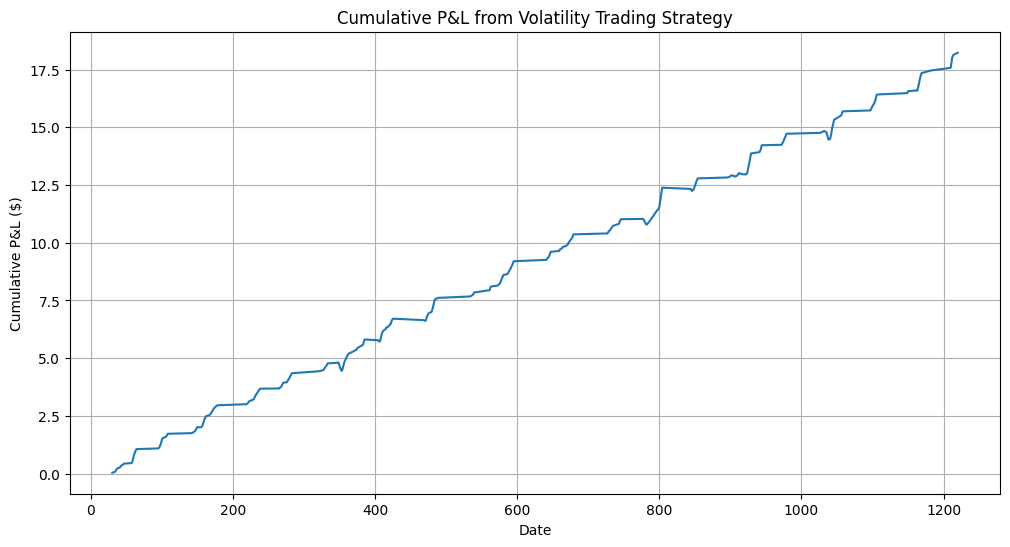

In [11]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price"""
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def simulate_vol_trading(df, lookback=30, vol_threshold=0.8, hold_days=5):
    """
    Simulate trading strategy selling options when IV is high
    
    Parameters:
    df: DataFrame with 'Implied Volatility' column
    lookback: Days to look back for vol percentile calculation
    vol_threshold: Percentile threshold to consider vol "high" 
    hold_days: Number of days to hold short option position
    """
    # Fixed option parameters
    S = 100  # Underlying price
    K = 100  # Strike price (at-the-money)
    r = 0.02 # Risk-free rate
    
    results = []
    
    for i in range(lookback, len(df)-hold_days):
        # Calculate rolling vol percentile
        vol_percentile = (
            df['Implied Volatility'].iloc[i] > 
            df['Implied Volatility'].iloc[i-lookback:i].quantile(vol_threshold)
        )
        
        # If vol is high, simulate selling an option
        if vol_percentile:
            entry_vol = df['Implied Volatility'].iloc[i]
            exit_vol = df['Implied Volatility'].iloc[i+hold_days]
            
            # Calculate option prices
            T_entry = 30/365  # 30-day option at entry
            T_exit = (30-hold_days)/365  # Remaining time at exit
            
            entry_price = black_scholes(S, K, T_entry, r, entry_vol)
            exit_price = black_scholes(S, K, T_exit, r, exit_vol)
            
            # Calculate P&L (selling high vol, buying back lower vol)
            pnl = entry_price - exit_price
            
            results.append({
                'Entry_Date': df.index[i],
                'Exit_Date': df.index[i+hold_days],
                'Entry_Vol': entry_vol,
                'Exit_Vol': exit_vol,
                'Entry_Price': entry_price,
                'Exit_Price': exit_price,
                'PnL': pnl
            })
    
    return pd.DataFrame(results)

# Run simulation
trading_results = simulate_vol_trading(implied_vol)

# Calculate strategy metrics
total_pnl = trading_results['PnL'].sum()
win_rate = (trading_results['PnL'] > 0).mean()
avg_win = trading_results[trading_results['PnL'] > 0]['PnL'].mean()
avg_loss = trading_results[trading_results['PnL'] < 0]['PnL'].mean()

print("\nTrading Strategy Results:")
print(f"Total P&L: ${total_pnl:.2f}")
print(f"Number of Trades: {len(trading_results)}")
print(f"Win Rate: {win_rate:.1%}")
print(f"Average Win: ${avg_win:.2f}")
print(f"Average Loss: ${avg_loss:.2f}")

# Plot P&L over time
plt.figure(figsize=(12,6))
plt.plot(trading_results['Entry_Date'], trading_results['PnL'].cumsum())
plt.title('Cumulative P&L from Volatility Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L ($)')
plt.grid(True)
plt.show()


### Considerations

While selling options during periods of high implied volatility can be an attractive strategy to capture the volatility risk premium, there are several important considerations and risks to keep in mind:

#### 1. Time Decay vs Volatility Contraction
- Even if implied volatility is elevated, theta (time decay) may erode the option's value faster than volatility contracts
- This means you could end up with a loss even if your volatility thesis is correct, just not quickly enough
- The trade-off between theta and vega exposure needs to be carefully balanced

#### 2. Volatility Can Go Higher
- High implied volatility can always go higher, especially during periods of market stress
- This creates potentially significant mark-to-market losses
- Risk management and position sizing become critical

#### 3. Gap Risk
- Short options have theoretically unlimited risk
- Market gaps or black swan events can lead to losses far exceeding the premium collected
- This is especially relevant when volatility is high, as it often signals market uncertainty

#### 4. Margin Requirements
- Higher volatility typically means higher margin requirements
- This reduces capital efficiency and return on capital
- Margin calls become more likely if positions move against you

#### 5. Correlation Risk
- During high volatility periods, correlations often break down
- Traditional hedging relationships may not work as expected
- This can impact both directional and volatility hedges

These factors underscore the importance of careful risk management and position sizing when implementing volatility selling strategies.

## The Reality of Volatility Trading

While the concepts and strategies discussed may seem straightforward, successfully trading volatility is an incredibly complex and demanding endeavor:

#### 1. Multi-Disciplinary Challenge
- Requires deep understanding of mathematics, statistics, and computer science
- Must grasp complex financial theories and market mechanics
- Need for strong programming skills to implement and backtest strategies

#### 2. Dynamic Market Environment
- Market regimes shift constantly, invalidating historical relationships
- What worked yesterday may not work tomorrow
- Requires continuous adaptation and model refinement

#### 3. Resource Intensive
- Demands significant computational power for real-time analysis
- Requires substantial time investment in research and monitoring
- Need for sophisticated data infrastructure and tools

#### 4. Professional Role
- This is why volatility trading is typically a full-time professional pursuit
- Not suitable as a "set and forget" strategy
- Requires constant vigilance and risk management

The complexity and demands of volatility trading explain why it's primarily the domain of professional traders and institutions with dedicated resources. Success requires not just understanding the components, but maintaining a constant pulse on their evolving interactions.

